<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>HSC Template Analysis May 2023</b> <br>
Contact author: Erin Howard<br>
Last verified to run: June 1, 2023<br>
LSST Science Piplines version: w_2023_21<br>
Container Size: Large <br>

# DM-38242: HSC Template Analysis May 2023

## Run details

* Used weekly `w_2023_19` with `calibrate:config:doDeblend:False` for ApTemplate.
* Used weekly `w_2023_21` for ApPipe.
* Working directory on USDF with bps logs, pipelines, etc. is `/sdf/data/rubin/user/elhoward/repo-main-logs/DM-38242`
* Final processing of HSC COSMOS temlates is in `u/elhoward/DM-38242/templates`
* Final processing of HSC COSMOS is in `u/elhoward/DM-38242/HSC`

For ApPipeTemplates.yaml:
```
inCollection: HSC/raw/RC2/9813,HSC/calib,HSC/masks,refcats,skymaps
dataQuery: "instrument='HSC' AND skymap='hsc_rings_v1' AND band IN ('g', 'r', 'i', 'z', 'y')"
```

For ApPipe.yaml:
```
inCollection: u/elhoward/DM-38242/templates
dataQuery: "instrument='HSC' AND skymap='hsc_rings_v1' AND band IN ('g', 'r', 'i', 'z', 'y')"
```

## Analysis Summary

* New templates (and the difference between weekly 19 and weekly 21) do not result in significant changes.

## Table of Contents

1. [Loading DiaObjects and DiaSources](#section_1)
2. [DIA object and source visual analysis](#section_2)
3. [Comparing with the old ApPipe run](#section_3)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb

## 1. <a id="section_1">Loading DiaObjects and DiaSources</a>

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='lsst-devl'

fakeStatus = 'no fakes'

dmnum = '38242'
collections = f'u/elhoward/DM-{dmnum}/HSC'
schema = f'elhoward_dm{dmnum}_hsc_appipe'
month = 'May'
year = '2023'

dmnum_old = '38590'
collections_old = f'u/elhoward/DM-{dmnum_old}/HSC'
schema_old = f'elhoward_dm{dmnum_old}_hsc_appipe'
month_old = 'April'
year_old = '2023'

collectionsList = [collections,collections_old]

In [3]:
apdbQuery = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema)

In [4]:
with apdbQuery.connection as connection:
    srcTable = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "decl", "ccdVisitId" \
                                 FROM "{}"."DiaSource";'.format(schema), connection)

In [5]:
with apdbQuery.connection as connection:
    objTable = pd.read_sql_query('SELECT "diaObjectId", "ra", "decl", "nDiaSources" \
                                 FROM "{}"."DiaObject" \
                                 WHERE "validityEnd" is NULL;'.format(schema), connection)

In [6]:
apdbQuery_old = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema_old)

In [7]:
with apdbQuery_old.connection as connection:
    srcTable_old = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "decl", "ccdVisitId" \
                                     FROM "{}"."DiaSource";'.format(schema_old), connection)

In [8]:
with apdbQuery_old.connection as connection:
    objTable_old = pd.read_sql_query('SELECT "diaObjectId", "ra", "decl", "nDiaSources" \
                                     FROM "{}"."DiaObject" \
                                     WHERE "validityEnd" is NULL;'.format(schema_old), connection)

## 2. <a id="section_2">DIA object and source visual analysis</a>

(0.0, 60.0)

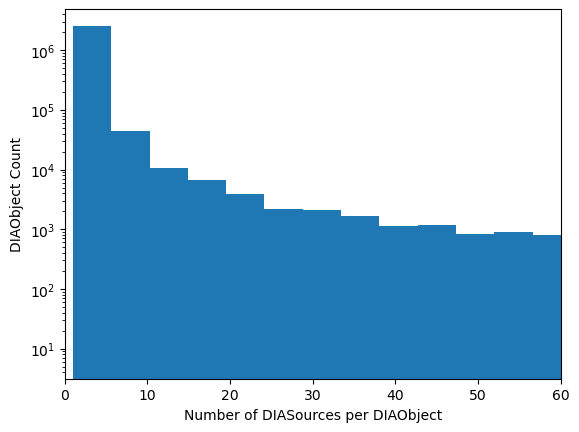

In [9]:
count = objTable['nDiaSources'].values
plt.figure()
plt.hist(count, bins=30)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')
plt.gca().set_xlim([0, 60])

Text(0, 0.5, 'Dec')

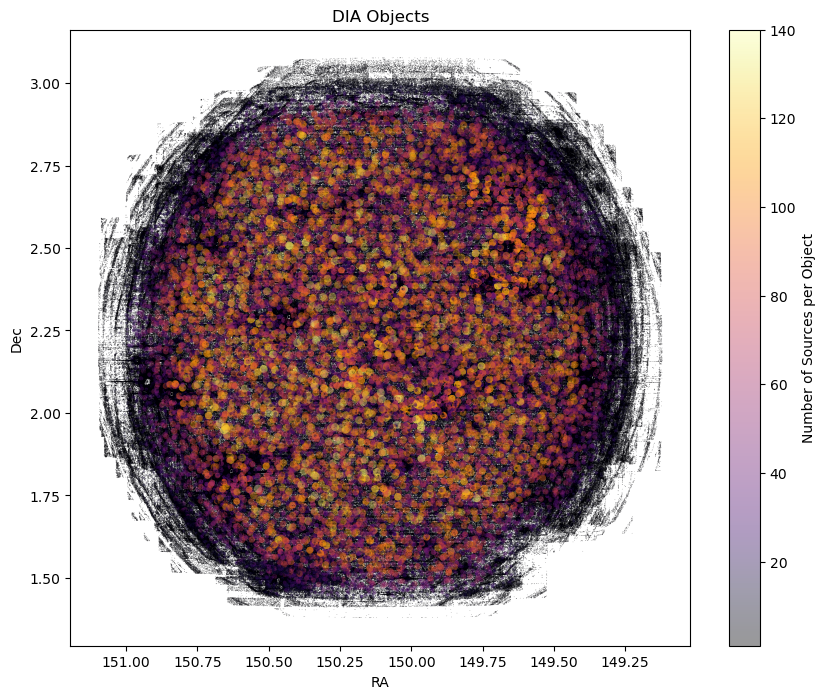

In [10]:
fig = plt.figure(facecolor='white', figsize=(10,8))

ax1 = fig.add_subplot(111)
ax1.set_facecolor('white')
plot1 = ax1.scatter(objTable['ra'], objTable['decl'], marker='.',
                  lw=0, s=objTable['nDiaSources'], c=objTable['nDiaSources'],
                  alpha=0.4, cmap='inferno')
plt.title('DIA Objects')
plt.xlabel('RA')
plt.ylabel('Dec')
ax1.invert_xaxis()
cb = fig.colorbar(plot1)
cb.set_label('Number of Sources per Object')

plt.xlabel('RA')
plt.ylabel('Dec')

## 3. <a id="section_3">Comparing with the old ApPipe run</a>

### Investigating a region

In [11]:
mini_region = ((objTable['decl'] > 2.1) & (objTable['decl'] < 2.2) & 
               (objTable['ra'] > 149.75) & (objTable['ra'] < 149.9) &
               (objTable['nDiaSources'] > 1))

mini_region_old = ((objTable_old['decl'] > 2.1) & (objTable_old['decl'] < 2.2) & 
                   (objTable_old['ra'] > 149.75) & (objTable_old['ra'] < 149.9) &
                   (objTable_old['nDiaSources'] > 1))

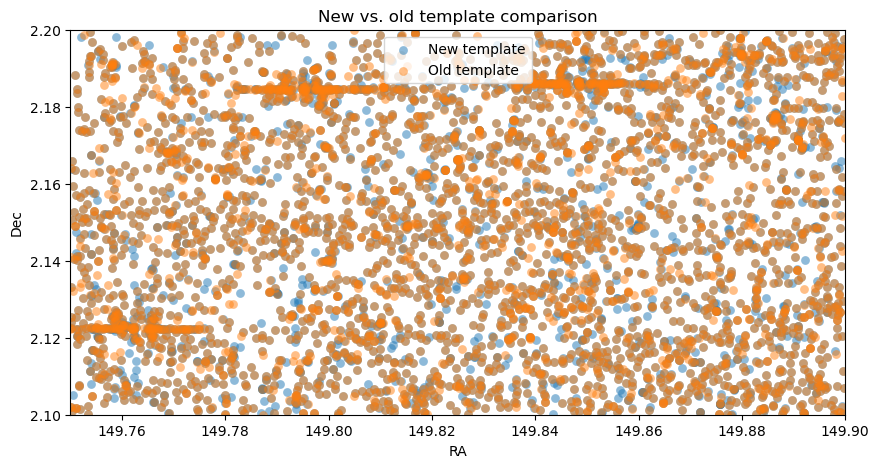

In [12]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

new_visits = ax3.scatter(objTable.loc[mini_region, 'ra'], objTable.loc[mini_region, 'decl'],
                         marker='o', lw=0, alpha=0.5, s=40, color='C0', label='New template')

old_visits = ax3.scatter(objTable_old.loc[mini_region_old, 'ra'], objTable_old.loc[mini_region_old, 'decl'],
                         marker='o', lw=0, alpha=0.5, s=40, color='C1', label='Old template')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('New vs. old template comparison')
plt.legend()
plt.xlim([149.9, 149.75])
plt.ylim([2.1, 2.2])
ax3.invert_xaxis()

(2.1, 2.2)

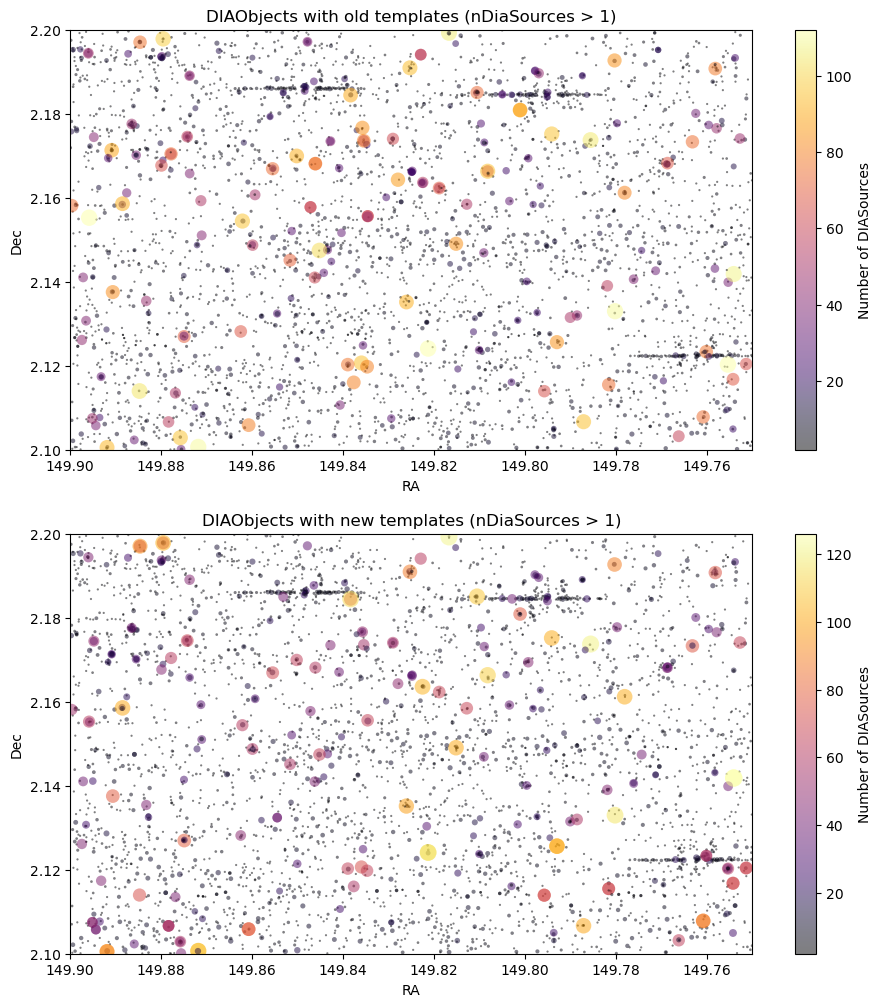

In [13]:
# Plot both old template run and new template run side by side

fig = plt.figure(facecolor='white', figsize=(11,12))

ax1 = fig.add_subplot(211)
cb1 = ax1.scatter(objTable_old.loc[mini_region_old, 'ra'], objTable_old.loc[mini_region_old, 'decl'], marker='.',
                  lw=0, s=objTable_old.loc[mini_region_old, 'nDiaSources']*5, c=objTable_old.loc[mini_region_old, 'nDiaSources'],
                  alpha=0.5, cmap=plt.cm.get_cmap('inferno'))
cbplot1 = plt.colorbar(cb1, ax=ax1)
cbplot1.set_label('Number of DIASources')
#cbplot1.set_clim(0, 60)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('DIAObjects with old templates (nDiaSources > 1)')
plt.xlim([149.9, 149.75])
plt.ylim([2.1, 2.2])


ax2 = fig.add_subplot(212)
cb2 = ax2.scatter(objTable.loc[mini_region, 'ra'], objTable.loc[mini_region, 'decl'], marker='.',
                  lw=0, s=objTable.loc[mini_region, 'nDiaSources']*5, c=objTable.loc[mini_region, 'nDiaSources'],
                  alpha=0.5, cmap=plt.cm.get_cmap('inferno'))
cbplot2 = plt.colorbar(cb2, ax=ax2)
cbplot2.set_label('Number of DIASources')
#cbplot2.set_clim(0, 60)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('DIAObjects with new templates (nDiaSources > 1)')
plt.xlim([149.9, 149.75])
plt.ylim([2.1, 2.2])

### Investigating two visits

In [14]:
compare_visits = [64443, 65643]

new_objects = []
for compare_visit in compare_visits:
    new_objects.extend(srcTable.loc[srcTable['ccdVisitId'] == compare_visit, 'diaObjectId'].values)

In [15]:
old_objects = []
for compare_visit in compare_visits:
    old_objects.extend(srcTable_old.loc[srcTable_old['ccdVisitId'] == compare_visit, 'diaObjectId'].values)

In [16]:
mask = objTable[objTable['diaObjectId'].isin(new_objects)]
mask_old = objTable_old[objTable_old['diaObjectId'].isin(old_objects)]

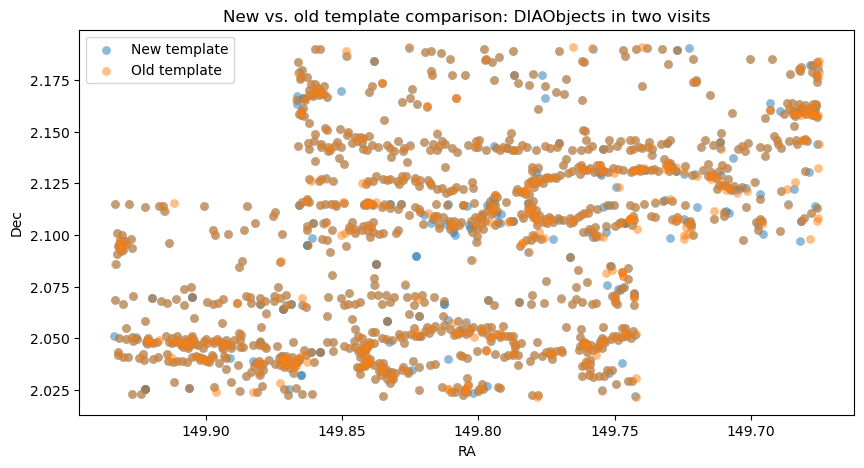

In [17]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

new_visits = ax3.scatter(mask['ra'], mask['decl'],
                         marker='o', lw=0, alpha=0.5, s=40, color='C0', label='New template')

old_visits = ax3.scatter(mask_old['ra'], mask_old['decl'],
                         marker='o', lw=0, alpha=0.5, s=40, color='C1', label='Old template')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('New vs. old template comparison: DIAObjects in two visits')
plt.legend()
ax3.invert_xaxis()